In [31]:
import zipfile
import pandas as pd
import io
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np


# Path to the ZIP file
zip_file_path = 'data_YourNextPurchase.zip'

# Dictionary to store DataFrames
dataframes = {}

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # List all files in the ZIP
    file_names = zip_ref.namelist()
    
    # Load CSV files into DataFrames
    for file_name in file_names:
        if file_name.endswith('.csv'):
            with zip_ref.open(file_name) as file:
                # Read the CSV file into a DataFrame
                df_name = file_name.split('/')[-1].split('.')[0]  # Use the file name (without extension) as key
                dataframes[df_name] = pd.read_csv(io.TextIOWrapper(file, encoding='utf-8'))
                
                
# Extract individual dataframes from the dictionary
clients_df = dataframes['clients']
products_df = dataframes['products']
stocks_df = dataframes['stocks']
stores_df = dataframes['stores']
transactions_df = dataframes['transactions']

In [32]:
# List columns of each DataFrame
print("Columns in clients_df:", clients_df.columns.tolist())
print("Columns in products_df:", products_df.columns.tolist())
print("Columns in stocks_df:", stocks_df.columns.tolist())
print("Columns in stores_df:", stores_df.columns.tolist())
print("Columns in transactions_df:", transactions_df.columns.tolist())

Columns in clients_df: ['ClientID', 'ClientSegment', 'ClientCountry', 'ClientOptINEmail', 'ClientOptINPhone', 'ClientGender', 'Age']
Columns in products_df: ['ProductID', 'Category', 'FamilyLevel1', 'FamilyLevel2', 'Universe']
Columns in stocks_df: ['StoreCountry', 'ProductID', 'Quantity']
Columns in stores_df: ['StoreID', 'StoreCountry']
Columns in transactions_df: ['ClientID', 'ProductID', 'SaleTransactionDate', 'StoreID', 'Quantity', 'SalesNetAmountEuro']


In [33]:
# Convert date column to datetime format for temporal aggregations
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['SaleTransactionDate'], errors='coerce')

# Filter out invalid ages
clients_df['Age'] = clients_df['Age'].apply(lambda x: x if (15 <= x <= 90) else None)

In [34]:
# Merge transactions with stores data to get store country information
transactions_with_stores = transactions_df.merge(stores_df, on='StoreID', how='left')
print("Shape after merge:", transactions_with_stores.shape)
display(transactions_with_stores)

# Merge transactions_with_stores with stocks data
transactions_with_stores_and_stocks = transactions_with_stores.merge(
    stocks_df[['ProductID', 'StoreCountry', 'Quantity']], 
    on=['ProductID', 'StoreCountry'],
    how='left',
    suffixes=('_sold', '_in_stock')
)

print("Shape after merge:", transactions_with_stores_and_stocks.shape)
display(transactions_with_stores_and_stocks)

# Merge transactions_with_stores_and_stocks with products data
transactions_complete = transactions_with_stores_and_stocks.merge(
    products_df[['ProductID', 'Category', 'FamilyLevel1', 'FamilyLevel2', 'Universe']], 
    on='ProductID',
    how='left'
)

print("Shape after merge:", transactions_complete.shape)
display(transactions_complete)

# Merge transactions_complete with clients data
final_df = transactions_complete.merge(
    clients_df[['ClientID', 'ClientSegment', 'ClientGender', 'Age', 'ClientCountry', 'ClientOptINEmail', 'ClientOptINPhone']], 
    on='ClientID',
    how='left'
)

print("Shape after merge:", final_df.shape)
display(final_df)

Shape after merge: (1177175, 8)


,ClientID,ProductID,SaleTransactionDate,StoreID,Quantity,SalesNetAmountEuro,TransactionDate,StoreCountry
0,8119209481417068505,3532473209579560668,2023-06-06 00:00:00+00:00,4821951108133690356,4,56.97,2023-06-06 00:00:00+00:00,GBR
1,2497726585282787281,5103640511191568912,2023-09-20 00:00:00+00:00,1450109522794525790,1,5.99,2023-09-20 00:00:00+00:00,FRA
2,7673687066317773168,4923931302917549451,2023-12-16 00:00:00+00:00,1821464542701843363,2,16.99,2023-12-16 00:00:00+00:00,ARE
3,1873234305263900608,8502620308847538595,2023-01-31 00:00:00+00:00,2686511472610728845,4,140.97,2023-01-31 00:00:00+00:00,FRA
4,3913817537779196185,8573693021421318503,2024-01-23 00:00:00+00:00,3600233866627167751,1,10.99,2024-01-23 00:00:00+00:00,GBR
...,...,...,...,...,...,...,...,...
1177170,2432651529788024626,8869820367595237769,2023-05-05 00:00:00+00:00,3306498059038628287,2,16.99,2023-05-05 00:00:00+00:00,USA
1177171,1691937543970001915,7039116905723644150,2023-11-12 00:00:00+00:00,3306498059038628287,1,5.99,2023-11-12 00:00:00+00:00,USA
1177172,1003100987571803008,242506609152720728,2024-09-25 00:00:00+00:00,9099531021898466037,1,29.99,2024-09-25 00:00:00+00:00,USA
1177173,5201324372064592752,412909163137289630,2025-01-22 00:00:00+00:00,7913334853958149044,2,29.99,2025-01-22 00:00:00+00:00,FRA


Shape after merge: (1177175, 9)


,ClientID,ProductID,SaleTransactionDate,StoreID,Quantity_sold,SalesNetAmountEuro,TransactionDate,StoreCountry,Quantity_in_stock
0,8119209481417068505,3532473209579560668,2023-06-06 00:00:00+00:00,4821951108133690356,4,56.97,2023-06-06 00:00:00+00:00,GBR,NaN
1,2497726585282787281,5103640511191568912,2023-09-20 00:00:00+00:00,1450109522794525790,1,5.99,2023-09-20 00:00:00+00:00,FRA,17.0
2,7673687066317773168,4923931302917549451,2023-12-16 00:00:00+00:00,1821464542701843363,2,16.99,2023-12-16 00:00:00+00:00,ARE,NaN
3,1873234305263900608,8502620308847538595,2023-01-31 00:00:00+00:00,2686511472610728845,4,140.97,2023-01-31 00:00:00+00:00,FRA,NaN
4,3913817537779196185,8573693021421318503,2024-01-23 00:00:00+00:00,3600233866627167751,1,10.99,2024-01-23 00:00:00+00:00,GBR,NaN
...,...,...,...,...,...,...,...,...,...
1177170,2432651529788024626,8869820367595237769,2023-05-05 00:00:00+00:00,3306498059038628287,2,16.99,2023-05-05 00:00:00+00:00,USA,3.0
1177171,1691937543970001915,7039116905723644150,2023-11-12 00:00:00+00:00,3306498059038628287,1,5.99,2023-11-12 00:00:00+00:00,USA,NaN
1177172,1003100987571803008,242506609152720728,2024-09-25 00:00:00+00:00,9099531021898466037,1,29.99,2024-09-25 00:00:00+00:00,USA,2.0
1177173,5201324372064592752,412909163137289630,2025-01-22 00:00:00+00:00,7913334853958149044,2,29.99,2025-01-22 00:00:00+00:00,FRA,3.0


Shape after merge: (1177175, 13)


,ClientID,ProductID,SaleTransactionDate,StoreID,Quantity_sold,SalesNetAmountEuro,TransactionDate,StoreCountry,Quantity_in_stock,Category,FamilyLevel1,FamilyLevel2,Universe
0,8119209481417068505,3532473209579560668,2023-06-06 00:00:00+00:00,4821951108133690356,4,56.97,2023-06-06 00:00:00+00:00,GBR,NaN,Rugby,Shorts,Canterbury Advantage,Women
1,2497726585282787281,5103640511191568912,2023-09-20 00:00:00+00:00,1450109522794525790,1,5.99,2023-09-20 00:00:00+00:00,FRA,17.0,Beach,Swimsuit,Speedo Fastskin LZR Racer X,Women
2,7673687066317773168,4923931302917549451,2023-12-16 00:00:00+00:00,1821464542701843363,2,16.99,2023-12-16 00:00:00+00:00,ARE,NaN,Baseball,Bat,Rawlings Quatro Pro,Men
3,1873234305263900608,8502620308847538595,2023-01-31 00:00:00+00:00,2686511472610728845,4,140.97,2023-01-31 00:00:00+00:00,FRA,NaN,Cycling,Bike,Specialized S-Works Roubaix,Men
4,3913817537779196185,8573693021421318503,2024-01-23 00:00:00+00:00,3600233866627167751,1,10.99,2024-01-23 00:00:00+00:00,GBR,NaN,Football,Shoes,Adidas Predator,Men
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177170,2432651529788024626,8869820367595237769,2023-05-05 00:00:00+00:00,3306498059038628287,2,16.99,2023-05-05 00:00:00+00:00,USA,3.0,Tennis,Ball,Wilson US Open,Women
1177171,1691937543970001915,7039116905723644150,2023-11-12 00:00:00+00:00,3306498059038628287,1,5.99,2023-11-12 00:00:00+00:00,USA,NaN,Cycling,Helmet,Bell Super 3R MIPS,Men
1177172,1003100987571803008,242506609152720728,2024-09-25 00:00:00+00:00,9099531021898466037,1,29.99,2024-09-25 00:00:00+00:00,USA,2.0,Football,Shorts,Nike Dri-FIT,Men
1177173,5201324372064592752,412909163137289630,2025-01-22 00:00:00+00:00,7913334853958149044,2,29.99,2025-01-22 00:00:00+00:00,FRA,3.0,Badminton,Shuttlecock,Yonex AS-30,Men


Shape after merge: (1177175, 19)


,ClientID,ProductID,SaleTransactionDate,StoreID,Quantity_sold,SalesNetAmountEuro,TransactionDate,StoreCountry,Quantity_in_stock,Category,FamilyLevel1,FamilyLevel2,Universe,ClientSegment,ClientGender,Age,ClientCountry,ClientOptINEmail,ClientOptINPhone
0,8119209481417068505,3532473209579560668,2023-06-06 00:00:00+00:00,4821951108133690356,4,56.97,2023-06-06 00:00:00+00:00,GBR,NaN,Rugby,Shorts,Canterbury Advantage,Women,LOYAL,F,NaN,GBR,1,0
1,2497726585282787281,5103640511191568912,2023-09-20 00:00:00+00:00,1450109522794525790,1,5.99,2023-09-20 00:00:00+00:00,FRA,17.0,Beach,Swimsuit,Speedo Fastskin LZR Racer X,Women,LOYAL,M,39.0,USA,1,1
2,7673687066317773168,4923931302917549451,2023-12-16 00:00:00+00:00,1821464542701843363,2,16.99,2023-12-16 00:00:00+00:00,ARE,NaN,Baseball,Bat,Rawlings Quatro Pro,Men,LOYAL,F,NaN,ARE,1,1
3,1873234305263900608,8502620308847538595,2023-01-31 00:00:00+00:00,2686511472610728845,4,140.97,2023-01-31 00:00:00+00:00,FRA,NaN,Cycling,Bike,Specialized S-Works Roubaix,Men,TOP,M,35.0,DEU,1,1
4,3913817537779196185,8573693021421318503,2024-01-23 00:00:00+00:00,3600233866627167751,1,10.99,2024-01-23 00:00:00+00:00,GBR,NaN,Football,Shoes,Adidas Predator,Men,LOYAL,F,NaN,GBR,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177170,2432651529788024626,8869820367595237769,2023-05-05 00:00:00+00:00,3306498059038628287,2,16.99,2023-05-05 00:00:00+00:00,USA,3.0,Tennis,Ball,Wilson US Open,Women,LOYAL,F,NaN,USA,0,0
1177171,1691937543970001915,7039116905723644150,2023-11-12 00:00:00+00:00,3306498059038628287,1,5.99,2023-11-12 00:00:00+00:00,USA,NaN,Cycling,Helmet,Bell Super 3R MIPS,Men,LOYAL,F,NaN,USA,1,1
1177172,1003100987571803008,242506609152720728,2024-09-25 00:00:00+00:00,9099531021898466037,1,29.99,2024-09-25 00:00:00+00:00,USA,2.0,Football,Shorts,Nike Dri-FIT,Men,LOYAL,F,36.0,USA,0,0
1177173,5201324372064592752,412909163137289630,2025-01-22 00:00:00+00:00,7913334853958149044,2,29.99,2025-01-22 00:00:00+00:00,FRA,3.0,Badminton,Shuttlecock,Yonex AS-30,Men,LOYAL,F,NaN,FRA,1,1


In [35]:
# Set 'U' gender values to null
clients_df.loc[clients_df['ClientGender'] == 'U', 'ClientGender'] = None

# Remove 'N' and 'C' values from ClientGender
clients_df.loc[clients_df['ClientGender'].isin(['N', 'C']), 'ClientGender'] = None

# Display the cleaned clients dataframe
display(clients_df)

,ClientID,ClientSegment,ClientCountry,ClientOptINEmail,ClientOptINPhone,ClientGender,Age
0,4508698145640552159,LOYAL,USA,1,1,M,NaN
1,2022746661324934183,INACTIVE_1Y,USA,0,1,F,NaN
2,5794452591674300222,LOYAL,USA,1,1,F,NaN
3,678556389231830160,LOYAL,USA,1,1,M,NaN
4,877301557964624234,LOYAL,USA,1,1,F,NaN
...,...,...,...,...,...,...,...
424032,6368205759336936904,LOYAL,USA,1,1,F,NaN
424033,6789036627132562875,LOYAL,USA,1,0,NaN,NaN
424034,6482790535813826054,LOYAL,USA,1,1,F,45.0
424035,6068605136251037073,LOYAL,USA,1,1,NaN,NaN


In [36]:
clients_df.to_csv('clients_dataset.csv', index=False)

In [37]:
# Replace NaN values in Quantity_in_stock with 0
final_df['Quantity_in_stock'] = final_df['Quantity_in_stock'].fillna(0)

# Set 'U' gender values to null
final_df.loc[final_df['ClientGender'] == 'U', 'ClientGender'] = None

# Remove 'N' and 'C' values from ClientGender
final_df.loc[final_df['ClientGender'].isin(['N', 'C']), 'ClientGender'] = None

In [38]:
# For each merge operation, let's check which rows didn't get matched

# 1. Check unmatched stores rows
unmatched_stores = stores_df[~stores_df['StoreID'].isin(transactions_df['StoreID'])]
num_unmatched_stores = len(unmatched_stores)
percentage_unmatched_stores = (num_unmatched_stores / len(stores_df)) * 100

print(f"\nNumber of stores not in any transaction: {num_unmatched_stores} ({percentage_unmatched_stores:.2f}%)")
if num_unmatched_stores > 0:
    print("\nExample of unmatched stores:")
    print(unmatched_stores.head())

# 2. Check unmatched stocks rows 
unmatched_stocks = stocks_df[~stocks_df['ProductID'].isin(transactions_df['ProductID'])]
num_unmatched_stocks = len(unmatched_stocks)
percentage_unmatched_stocks = (num_unmatched_stocks / len(stocks_df)) * 100

print(f"\nNumber of stock records with no matching transactions: {num_unmatched_stocks} ({percentage_unmatched_stocks:.2f}%)")
if num_unmatched_stocks > 0:
    print("\nExample of unmatched stocks:")
    print(unmatched_stocks.head())

# 3. Check unmatched products
unmatched_products = products_df[~products_df['ProductID'].isin(transactions_df['ProductID'])]
num_unmatched_products = len(unmatched_products)
percentage_unmatched_products = (num_unmatched_products / len(products_df)) * 100

print(f"\nNumber of products with no transactions: {num_unmatched_products} ({percentage_unmatched_products:.2f}%)")
if num_unmatched_products > 0:
    print("\nExample of unmatched products:")
    print(unmatched_products.head())

# 4. Check unmatched clients
unmatched_clients = clients_df[~clients_df['ClientID'].isin(transactions_df['ClientID'])]
num_unmatched_clients = len(unmatched_clients)
percentage_unmatched_clients = (num_unmatched_clients / len(clients_df)) * 100

print(f"\nNumber of clients with no transactions: {num_unmatched_clients} ({percentage_unmatched_clients:.2f}%)")
if num_unmatched_clients > 0:
    print("\nExample of unmatched clients:")
    print(unmatched_clients.head())


Number of stores not in any transaction: 455 (75.08%)

Example of unmatched stores:
               StoreID StoreCountry
0  7793989562498223120          BRA
1  5301108587679203543          BRA
2  2908896877692945358          BRA
3  2718131790848668199          BRA
4  7819332417840564556          BRA

Number of stock records with no matching transactions: 264 (1.65%)

Example of unmatched stocks:
    StoreCountry            ProductID  Quantity
7            AUS  7723338481459021739       3.0
191          AUS  2454887360203612522       1.0
192          AUS  6596210828396111483       1.0
196          AUS  2555019967478483592       2.0
560          AUS  3077353185423939874       1.0

Number of products with no transactions: 17728 (37.36%)

Example of unmatched products:
                 ProductID    Category FamilyLevel1          FamilyLevel2  \
29730  3704037523527266838  Basketball        Shoes  Nike Air Zoom BB NXT   
29731  6038168350332668241      Tennis         Ball        Wilson US O

In [39]:
# Elenco dei dataframe originali
original_dataframes = [clients_df, products_df, stocks_df, stores_df, transactions_df]

# Elenco dei nomi dei dataframe originali
dataframe_names = ['clients_df', 'products_df', 'stocks_df', 'stores_df', 'transactions_df']

# Colonne del dataframe finale
final_columns = final_df.columns.tolist()

# Controllo delle colonne mancanti
for df, name in zip(original_dataframes, dataframe_names):
    missing_columns = [col for col in df.columns if col not in final_columns]
    if missing_columns:
        print(f"Colonne mancanti in {name}: {missing_columns}")
    else:
        print(f"Tutte le colonne di {name} sono presenti in final_df")

Tutte le colonne di clients_df sono presenti in final_df
Tutte le colonne di products_df sono presenti in final_df
Colonne mancanti in stocks_df: ['Quantity']
Tutte le colonne di stores_df sono presenti in final_df
Colonne mancanti in transactions_df: ['Quantity']


In [40]:
# Compute number of transactions and average sales per client from final_df
client_tx_counts = final_df.groupby('ClientID').size()
client_avg_sales = final_df.groupby('ClientID')['SalesNetAmountEuro'].mean()

# Determine the 99.95th percentile thresholds (i.e. top 0.05%)
tx_threshold = np.percentile(client_tx_counts, 99)
sales_threshold = np.percentile(client_avg_sales, 99)

# Select top clients based on each metric
top_tx_clients = client_tx_counts[client_tx_counts >= tx_threshold].sort_values(ascending=False)
top_avg_sales_clients = client_avg_sales[client_avg_sales >= sales_threshold].sort_values(ascending=False)

print("Top 0.1% clients by number of transactions:")
display(top_tx_clients)

print("Top 0.1% clients by average euros per transaction:")
display(top_avg_sales_clients)

# Create sets from the client lists
high_frequency_clients = set(top_tx_clients.index)
high_amount_clients = set(top_avg_sales_clients.index)

# Print statistics about each set
print(f"Number of high frequency clients: {len(high_frequency_clients)}")
print(f"Number of high amount clients: {len(high_amount_clients)}")

# Find the union of both sets
combined_outlier_clients = high_frequency_clients | high_amount_clients

print(f"\nTotal number of unique outlier clients: {len(combined_outlier_clients)}")
print(f"Clients that appear in both sets: {len(high_frequency_clients & high_amount_clients)}")

Top 0.1% clients by number of transactions:


ClientID
784139077380372687     44460
3956811437678549470     2117
4763912924549386716     1300
2257027309541343162      996
7170141520984547731      971
                       ...  
3278083667962152151       34
3293684401490287382       34
7014499448641896394       34
3303868777967965956       34
5321166022465669301       34
Length: 3065, dtype: int64

Top 0.1% clients by average euros per transaction:


ClientID
1132261303486551948    16924.546667
1918889904232780836    13015.990000
3468904384835684271     6391.145789
8666581929021561288     4673.990000
5609349892117492319     4208.722667
                           ...     
2424516463387059525      169.980000
8659371831770251964      169.980000
3399635291345658636      169.980000
365384545458667119       169.980000
7611841936583005546      169.980000
Name: SalesNetAmountEuro, Length: 3077, dtype: float64

Number of high frequency clients: 3065
Number of high amount clients: 3077

Total number of unique outlier clients: 6119
Clients that appear in both sets: 23


In [41]:
# Calculate the 1st percentile threshold for SalesNetAmountEuro
price_threshold = np.percentile(final_df['SalesNetAmountEuro'], 1)

# Store total number of transactions before filtering
total_transactions_before_price_filter = len(final_df)

# Remove transactions with SalesNetAmountEuro below the threshold
final_df = final_df[final_df['SalesNetAmountEuro'] > price_threshold]

print(f"Number of transactions before price filtering: {total_transactions_before_price_filter}")
print(f"Number of transactions after price filtering: {len(final_df)}")
print(f"Percentage of transactions removed based on price: {((total_transactions_before_price_filter - len(final_df)) / total_transactions_before_price_filter * 100):.2f}%")

Number of transactions before price filtering: 1177175
Number of transactions after price filtering: 1164880
Percentage of transactions removed based on price: 1.04%


In [42]:
# Determine the 99.95th percentile threshold for SalesNetAmountEuro
sales_amount_threshold = np.percentile(final_df['SalesNetAmountEuro'], 99)

# Store total number of transactions before filtering
total_transactions_before_sales_filter = len(final_df)

# Remove transactions with SalesNetAmountEuro above the threshold
final_df = final_df[final_df['SalesNetAmountEuro'] <= sales_amount_threshold]

print(f"Number of transactions before sales amount filtering: {total_transactions_before_sales_filter}")
print(f"Number of transactions after sales amount filtering: {len(final_df)}")
print(f"Percentage of transactions removed based on sales amount: {((total_transactions_before_sales_filter - len(final_df)) / total_transactions_before_sales_filter * 100):.2f}%")

Number of transactions before sales amount filtering: 1164880
Number of transactions after sales amount filtering: 1153369
Percentage of transactions removed based on sales amount: 0.99%


In [43]:
# Store total number of transactions before filtering
total_transactions_before = len(final_df)

# Remove transactions for clients identified as outliers
# These are clients that exceed either the 99.95th percentile in transaction frequency 
# or in average sales amount
final_df = final_df[~final_df['ClientID'].isin(combined_outlier_clients)]

print(f"Number of transactions before filtering: {total_transactions_before}")
print(f"Number of transactions after filtering: {len(final_df)}")
print(f"Percentage of transactions removed: {((total_transactions_before - len(final_df)) / total_transactions_before * 100):.2f}%")

Number of transactions before filtering: 1153369
Number of transactions after filtering: 916268
Percentage of transactions removed: 20.56%


In [44]:
final_df = final_df.groupby([
    'ClientID', 'ProductID', 'TransactionDate', 'StoreID', 'StoreCountry', 
    'Quantity_in_stock', 'Category', 'FamilyLevel1', 'FamilyLevel2', 'Universe', 
    'ClientSegment', 'ClientGender', 'Age', 'ClientCountry', 'ClientOptINEmail', 'ClientOptINPhone'
], dropna=False).agg({
    'Quantity_sold': 'sum',
    'SalesNetAmountEuro': 'sum'
}).reset_index()

In [45]:
# Print data info for final_df
print("Final DataFrame Info:")
print(final_df.info())
display(final_df)

Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906724 entries, 0 to 906723
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   ClientID            906724 non-null  int64              
 1   ProductID           906724 non-null  int64              
 2   TransactionDate     906724 non-null  datetime64[ns, UTC]
 3   StoreID             906724 non-null  int64              
 4   StoreCountry        906724 non-null  object             
 5   Quantity_in_stock   906724 non-null  float64            
 6   Category            906724 non-null  object             
 7   FamilyLevel1        906724 non-null  object             
 8   FamilyLevel2        906724 non-null  object             
 9   Universe            906724 non-null  object             
 10  ClientSegment       906724 non-null  object             
 11  ClientGender        857365 non-null  object             

,ClientID,ProductID,TransactionDate,StoreID,StoreCountry,Quantity_in_stock,Category,FamilyLevel1,FamilyLevel2,Universe,ClientSegment,ClientGender,Age,ClientCountry,ClientOptINEmail,ClientOptINPhone,Quantity_sold,SalesNetAmountEuro
0,39370740138294,1440540189819119258,2024-12-17 00:00:00+00:00,7704230050291051317,GBR,0.0,Football,Jersey,Nike Away Jersey,Women,LOYAL,F,22.0,GBR,1,1,2,14.99
1,39370740138294,1830527890021285361,2024-10-27 00:00:00+00:00,4823099650757441528,GBR,0.0,Football,Shorts,Nike Dri-FIT,Women,LOYAL,F,22.0,GBR,1,1,1,13.99
2,39370740138294,3095307643986324846,2024-10-28 00:00:00+00:00,4823099650757441528,GBR,0.0,Handball,Ball,Select Ultimate,Men,LOYAL,F,22.0,GBR,1,1,2,78.99
3,41168361649132,4786639895536460836,2024-03-03 00:00:00+00:00,7913334853958149044,FRA,3.0,Badminton,Racket,Yonex Astrox 99,Women,LOYAL,F,NaN,FRA,1,1,3,21.98
4,118552773044620,7951360260357319889,2024-12-09 00:00:00+00:00,3306498059038628287,USA,1.0,Baseball,Glove,Wilson A2000,Men,LOYAL,F,52.0,USA,1,0,2,38.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906719,9223352473445645109,1102195885428775766,2025-02-05 00:00:00+00:00,7072849857188684803,ARE,13.0,Badminton,Shuttlecock,Victor Gold Champion,Men,LOYAL,F,NaN,ARE,0,0,1,27.99
906720,9223352473445645109,5760088997185117368,2024-05-08 00:00:00+00:00,7072849857188684803,ARE,0.0,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,1,26.99
906721,9223352473445645109,5760088997185117368,2024-05-21 00:00:00+00:00,7072849857188684803,ARE,0.0,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,1,5.99
906722,9223352473445645109,5760088997185117368,2024-05-23 00:00:00+00:00,7072849857188684803,ARE,0.0,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,2,23.99


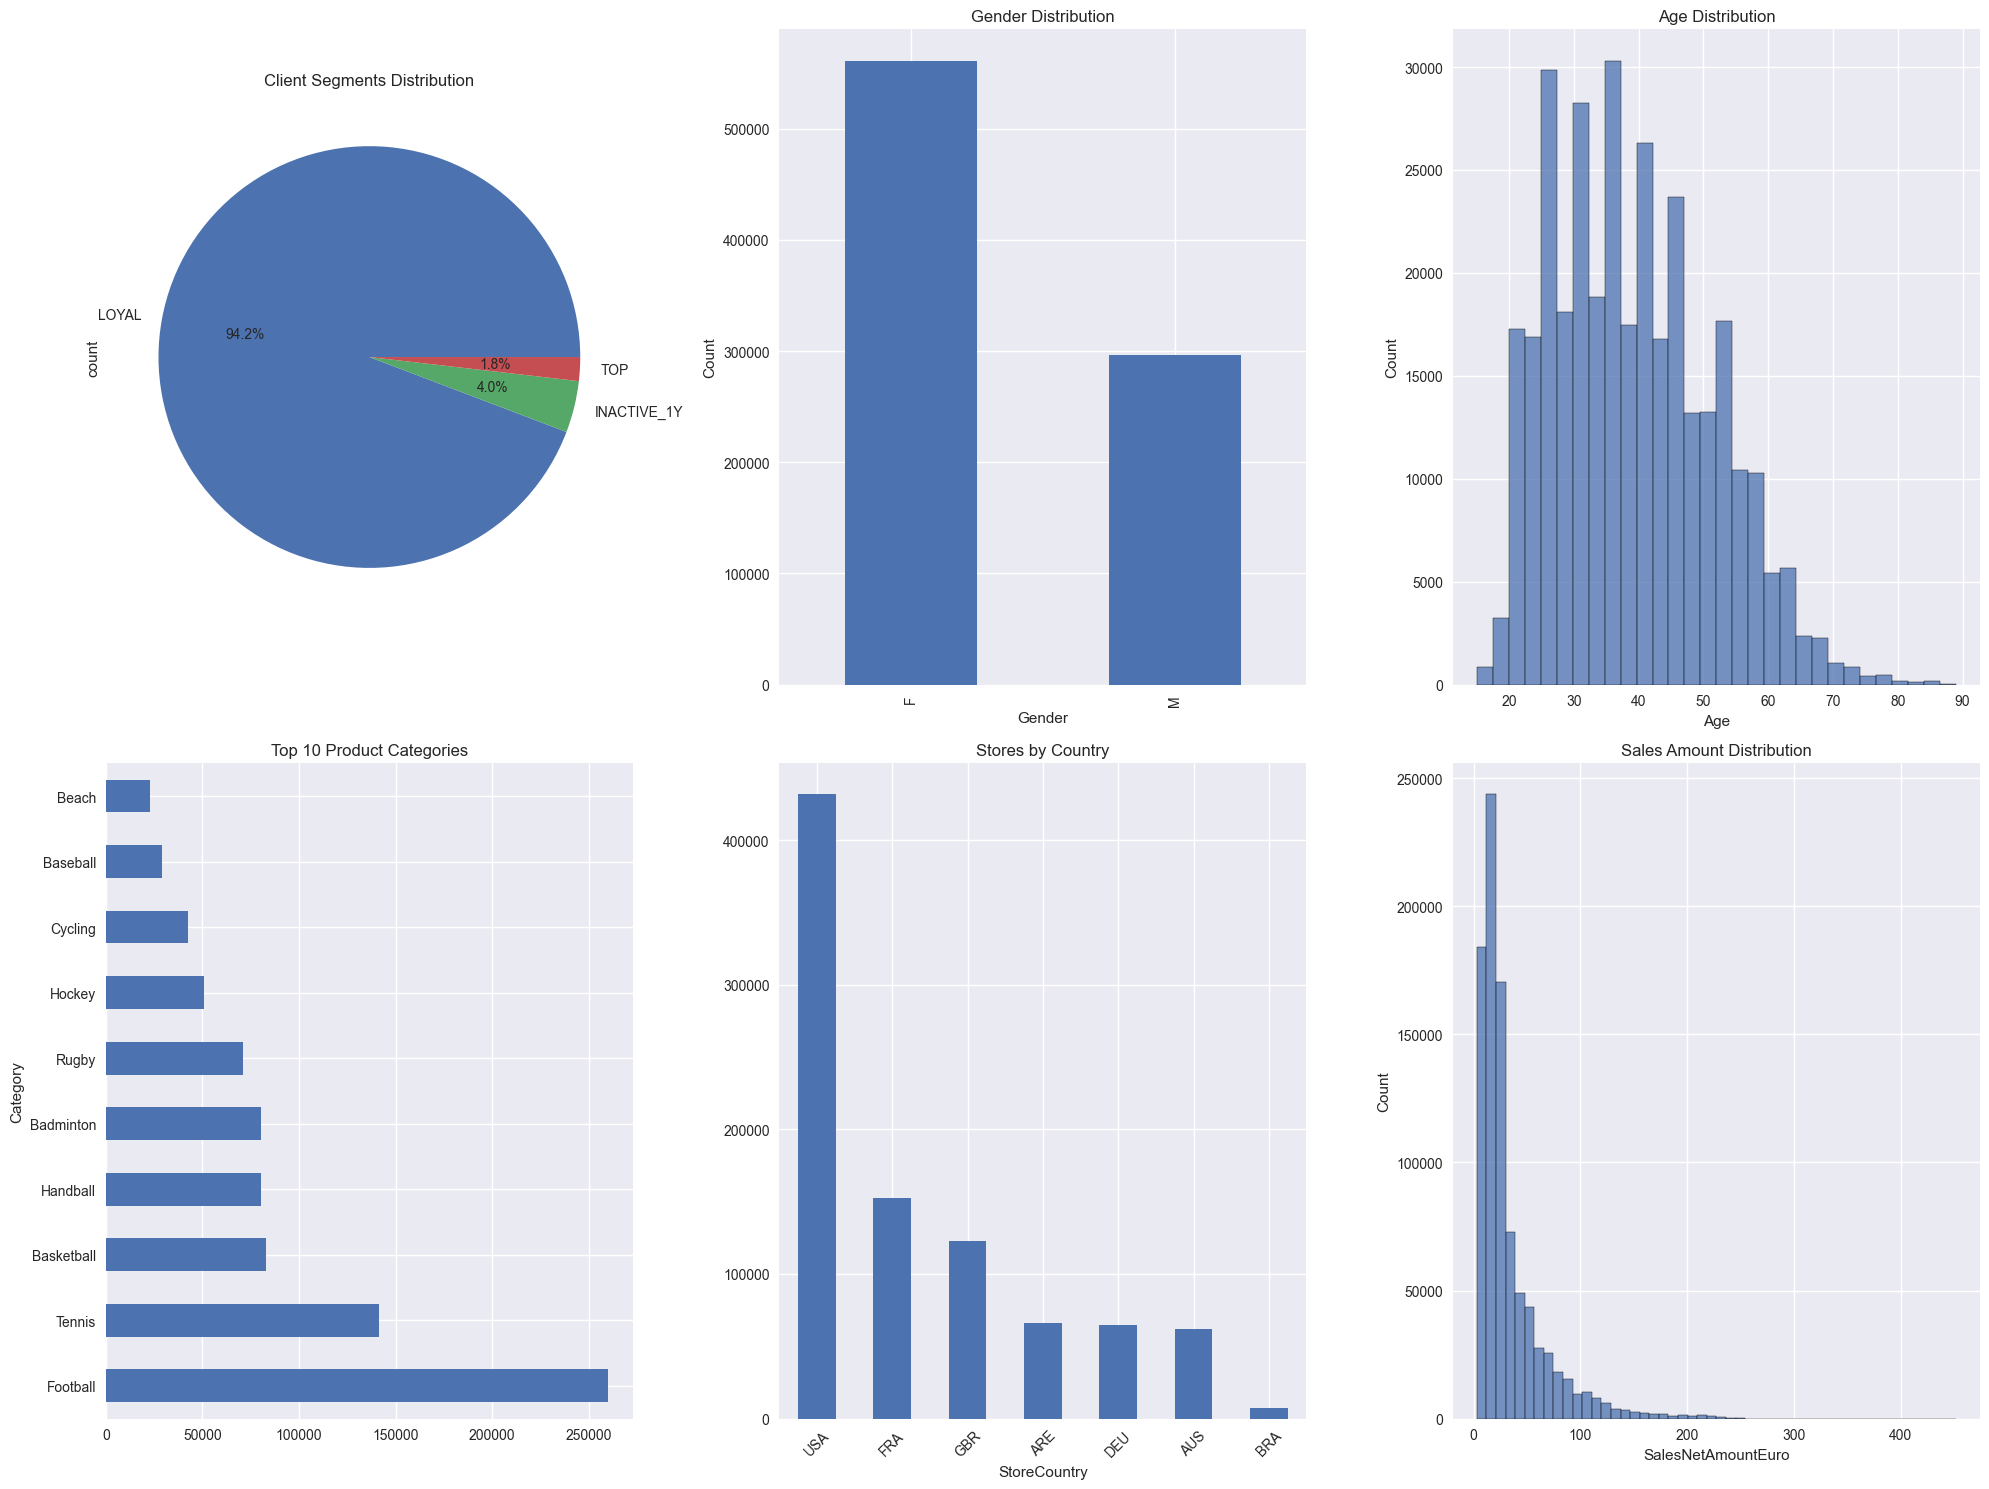

In [46]:
# Create a figure with subplots
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(20, 15))

# 1. Client Segments Distribution
plt.subplot(2, 3, 1)
final_df['ClientSegment'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Client Segments Distribution')

# 2. Gender Distribution
plt.subplot(2, 3, 2)
final_df['ClientGender'].value_counts().plot(kind='bar')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

# 3. Age Distribution
plt.subplot(2, 3, 3)
sns.histplot(data=final_df, x='Age', bins=30)
plt.title('Age Distribution')

# 4. Top 10 Product Categories
plt.subplot(2, 3, 4)
final_df['Category'].value_counts().head(10).plot(kind='barh')
plt.title('Top 10 Product Categories')

# 5. Store Distribution by Country
plt.subplot(2, 3, 5)
final_df['StoreCountry'].value_counts().plot(kind='bar')
plt.title('Stores by Country')
plt.xticks(rotation=45)

# 6. Sales Amount Distribution
plt.subplot(2, 3, 6)
sns.histplot(data=final_df, x='SalesNetAmountEuro', bins=50)
plt.title('Sales Amount Distribution')

plt.tight_layout()
plt.show()


In [47]:
# Sort the final_df by SalesNetAmountEuro in descending order and select the top 30 transactions
top_30_transactions = final_df.sort_values(by='SalesNetAmountEuro', ascending=False).head(30)

# Display the top 30 transactions
display(top_30_transactions)

,ClientID,ProductID,TransactionDate,StoreID,StoreCountry,Quantity_in_stock,Category,FamilyLevel1,FamilyLevel2,Universe,ClientSegment,ClientGender,Age,ClientCountry,ClientOptINEmail,ClientOptINPhone,Quantity_sold,SalesNetAmountEuro
114054,1160540505653172833,962938307709480792,2024-12-11 00:00:00+00:00,2651682027038496089,USA,0.0,Cycling,Helmet,Kask Protone,Men,LOYAL,F,NaN,USA,1,1,2,451.98
884187,8993724133864427393,2893616851514749639,2023-11-08 00:00:00+00:00,4442065516911749181,AUS,1.0,Handball,Shoes,Mizuno Wave Mirage,Men,LOYAL,NaN,35.0,AUS,0,0,6,427.96
565438,5753082526065381018,1109476817528134630,2024-10-13 00:00:00+00:00,3600233866627167751,GBR,0.0,Handball,Ball,Molten H3X5001,Men,LOYAL,F,56.0,USA,1,1,6,421.96
215520,2177043133829067059,1686736724068035049,2024-08-25 00:00:00+00:00,1450109522794525790,FRA,0.0,Golf,Clubs,TaylorMade SIM2 Driver,Women,LOYAL,M,52.0,USA,1,1,3,418.98
548058,5581352070594455056,3095307643986324846,2023-06-18 00:00:00+00:00,8573865344522922182,AUS,1.0,Handball,Ball,Select Ultimate,Men,LOYAL,F,25.0,AUS,1,0,8,382.95
565622,5755008154387978511,8931596987236235888,2024-12-15 00:00:00+00:00,6490882301505443815,USA,0.0,Handball,Shoes,Asics Gel-Blast,Women,TOP,M,25.0,USA,1,1,3,358.98
101497,1032152694377596116,86876440051566286,2024-10-04 00:00:00+00:00,6056406535832467469,USA,2.0,Handball,Shoes,Asics Gel-Blast,Men,TOP,M,61.0,USA,1,1,6,355.96
835799,8505477873269629716,842211350300147019,2024-08-04 00:00:00+00:00,7716007625050232825,ARE,3.0,Handball,Ball,Molten H3X5001,Men,LOYAL,M,NaN,ARE,1,1,4,347.97
404397,4101435575002156124,8433678881546183797,2024-06-19 00:00:00+00:00,3306498059038628287,USA,5.0,Badminton,Racket,Yonex Astrox 99,Men,LOYAL,M,NaN,USA,1,0,8,345.94
602859,6139220823057126145,3899002091872130991,2023-05-21 00:00:00+00:00,7215875119995113089,AUS,1.0,Handball,Ball,Select Ultimate,Women,LOYAL,F,24.0,AUS,1,1,7,344.95


In [48]:
# Add a new column 'product_price' which is the total money spent divided by the number of articles
final_df['product_avg_price_order'] = final_df['SalesNetAmountEuro'] / final_df['Quantity_sold']

# Display the updated DataFrame
display(final_df)

,ClientID,ProductID,TransactionDate,StoreID,StoreCountry,Quantity_in_stock,Category,FamilyLevel1,FamilyLevel2,Universe,ClientSegment,ClientGender,Age,ClientCountry,ClientOptINEmail,ClientOptINPhone,Quantity_sold,SalesNetAmountEuro,product_avg_price_order
0,39370740138294,1440540189819119258,2024-12-17 00:00:00+00:00,7704230050291051317,GBR,0.0,Football,Jersey,Nike Away Jersey,Women,LOYAL,F,22.0,GBR,1,1,2,14.99,7.495000
1,39370740138294,1830527890021285361,2024-10-27 00:00:00+00:00,4823099650757441528,GBR,0.0,Football,Shorts,Nike Dri-FIT,Women,LOYAL,F,22.0,GBR,1,1,1,13.99,13.990000
2,39370740138294,3095307643986324846,2024-10-28 00:00:00+00:00,4823099650757441528,GBR,0.0,Handball,Ball,Select Ultimate,Men,LOYAL,F,22.0,GBR,1,1,2,78.99,39.495000
3,41168361649132,4786639895536460836,2024-03-03 00:00:00+00:00,7913334853958149044,FRA,3.0,Badminton,Racket,Yonex Astrox 99,Women,LOYAL,F,NaN,FRA,1,1,3,21.98,7.326667
4,118552773044620,7951360260357319889,2024-12-09 00:00:00+00:00,3306498059038628287,USA,1.0,Baseball,Glove,Wilson A2000,Men,LOYAL,F,52.0,USA,1,0,2,38.99,19.495000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906719,9223352473445645109,1102195885428775766,2025-02-05 00:00:00+00:00,7072849857188684803,ARE,13.0,Badminton,Shuttlecock,Victor Gold Champion,Men,LOYAL,F,NaN,ARE,0,0,1,27.99,27.990000
906720,9223352473445645109,5760088997185117368,2024-05-08 00:00:00+00:00,7072849857188684803,ARE,0.0,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,1,26.99,26.990000
906721,9223352473445645109,5760088997185117368,2024-05-21 00:00:00+00:00,7072849857188684803,ARE,0.0,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,1,5.99,5.990000
906722,9223352473445645109,5760088997185117368,2024-05-23 00:00:00+00:00,7072849857188684803,ARE,0.0,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,2,23.99,11.995000


In [49]:
unique_products = final_df['ProductID'].unique()
print(f"Number of unique products: {len(unique_products)}")

Number of unique products: 25239


In [50]:
from scipy.stats import zscore

# Loop through each product and calculate its normalized price distribution
for product_id in unique_products:  # Loop through all products
    # Normalize the product prices
    final_df.loc[final_df['ProductID'] == product_id, 'normalized_price'] = zscore(final_df[final_df['ProductID'] == product_id]['product_avg_price_order'])


In [51]:
# Filter out transactions with normalized price greater than 4
final_df = final_df[final_df['normalized_price'] <= 4]

# Drop the normalized_price column as it's no longer needed
final_df = final_df.drop(columns=['normalized_price'])

# Display the updated DataFrame
display(final_df)

,ClientID,ProductID,TransactionDate,StoreID,StoreCountry,Quantity_in_stock,Category,FamilyLevel1,FamilyLevel2,Universe,ClientSegment,ClientGender,Age,ClientCountry,ClientOptINEmail,ClientOptINPhone,Quantity_sold,SalesNetAmountEuro,product_avg_price_order
0,39370740138294,1440540189819119258,2024-12-17 00:00:00+00:00,7704230050291051317,GBR,0.0,Football,Jersey,Nike Away Jersey,Women,LOYAL,F,22.0,GBR,1,1,2,14.99,7.495000
1,39370740138294,1830527890021285361,2024-10-27 00:00:00+00:00,4823099650757441528,GBR,0.0,Football,Shorts,Nike Dri-FIT,Women,LOYAL,F,22.0,GBR,1,1,1,13.99,13.990000
2,39370740138294,3095307643986324846,2024-10-28 00:00:00+00:00,4823099650757441528,GBR,0.0,Handball,Ball,Select Ultimate,Men,LOYAL,F,22.0,GBR,1,1,2,78.99,39.495000
3,41168361649132,4786639895536460836,2024-03-03 00:00:00+00:00,7913334853958149044,FRA,3.0,Badminton,Racket,Yonex Astrox 99,Women,LOYAL,F,NaN,FRA,1,1,3,21.98,7.326667
4,118552773044620,7951360260357319889,2024-12-09 00:00:00+00:00,3306498059038628287,USA,1.0,Baseball,Glove,Wilson A2000,Men,LOYAL,F,52.0,USA,1,0,2,38.99,19.495000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906719,9223352473445645109,1102195885428775766,2025-02-05 00:00:00+00:00,7072849857188684803,ARE,13.0,Badminton,Shuttlecock,Victor Gold Champion,Men,LOYAL,F,NaN,ARE,0,0,1,27.99,27.990000
906720,9223352473445645109,5760088997185117368,2024-05-08 00:00:00+00:00,7072849857188684803,ARE,0.0,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,1,26.99,26.990000
906721,9223352473445645109,5760088997185117368,2024-05-21 00:00:00+00:00,7072849857188684803,ARE,0.0,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,1,5.99,5.990000
906722,9223352473445645109,5760088997185117368,2024-05-23 00:00:00+00:00,7072849857188684803,ARE,0.0,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,2,23.99,11.995000


In [52]:
# Calculate the total quantities and total sales for each product
product_totals = final_df.groupby('ProductID').agg({'Quantity_sold': 'sum', 'SalesNetAmountEuro': 'sum'})

# Calculate the average price for each product
product_totals['avg_price'] = product_totals['SalesNetAmountEuro'] / product_totals['Quantity_sold']

# Merge the average price back into the final_df
final_df = final_df.merge(product_totals[['avg_price']], on='ProductID', how='left')

# Display the updated DataFrame
display(final_df)

,ClientID,ProductID,TransactionDate,StoreID,StoreCountry,Quantity_in_stock,Category,FamilyLevel1,FamilyLevel2,Universe,ClientSegment,ClientGender,Age,ClientCountry,ClientOptINEmail,ClientOptINPhone,Quantity_sold,SalesNetAmountEuro,product_avg_price_order,avg_price
0,39370740138294,1440540189819119258,2024-12-17 00:00:00+00:00,7704230050291051317,GBR,0.0,Football,Jersey,Nike Away Jersey,Women,LOYAL,F,22.0,GBR,1,1,2,14.99,7.495000,8.337189
1,39370740138294,1830527890021285361,2024-10-27 00:00:00+00:00,4823099650757441528,GBR,0.0,Football,Shorts,Nike Dri-FIT,Women,LOYAL,F,22.0,GBR,1,1,1,13.99,13.990000,9.181570
2,39370740138294,3095307643986324846,2024-10-28 00:00:00+00:00,4823099650757441528,GBR,0.0,Handball,Ball,Select Ultimate,Men,LOYAL,F,22.0,GBR,1,1,2,78.99,39.495000,53.883987
3,41168361649132,4786639895536460836,2024-03-03 00:00:00+00:00,7913334853958149044,FRA,3.0,Badminton,Racket,Yonex Astrox 99,Women,LOYAL,F,NaN,FRA,1,1,3,21.98,7.326667,9.759794
4,118552773044620,7951360260357319889,2024-12-09 00:00:00+00:00,3306498059038628287,USA,1.0,Baseball,Glove,Wilson A2000,Men,LOYAL,F,52.0,USA,1,0,2,38.99,19.495000,26.422090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902003,9223352473445645109,1102195885428775766,2025-02-05 00:00:00+00:00,7072849857188684803,ARE,13.0,Badminton,Shuttlecock,Victor Gold Champion,Men,LOYAL,F,NaN,ARE,0,0,1,27.99,27.990000,16.059312
902004,9223352473445645109,5760088997185117368,2024-05-08 00:00:00+00:00,7072849857188684803,ARE,0.0,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,1,26.99,26.990000,15.618155
902005,9223352473445645109,5760088997185117368,2024-05-21 00:00:00+00:00,7072849857188684803,ARE,0.0,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,1,5.99,5.990000,15.618155
902006,9223352473445645109,5760088997185117368,2024-05-23 00:00:00+00:00,7072849857188684803,ARE,0.0,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,2,23.99,11.995000,15.618155


In [53]:
# Check missing values in final_df as percentages
missing_values = (final_df.isnull().sum() / len(final_df) * 100).round(2)
print("Missing values in final_df (%):")
print(missing_values)

Missing values in final_df (%):
ClientID                    0.00
ProductID                   0.00
TransactionDate             0.00
StoreID                     0.00
StoreCountry                0.00
Quantity_in_stock           0.00
Category                    0.00
FamilyLevel1                0.00
FamilyLevel2                0.00
Universe                    0.00
ClientSegment               0.00
ClientGender                5.46
Age                        63.40
ClientCountry               0.00
ClientOptINEmail            0.00
ClientOptINPhone            0.00
Quantity_sold               0.00
SalesNetAmountEuro          0.00
product_avg_price_order     0.00
avg_price                   0.00
dtype: float64


C:\Users\rikyr\AppData\Local\Temp\ipykernel_7920\4042708251.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sales_by_month = final_df.groupby(final_df['TransactionDate'].dt.to_period('M'))['SalesNetAmountEuro'].sum()


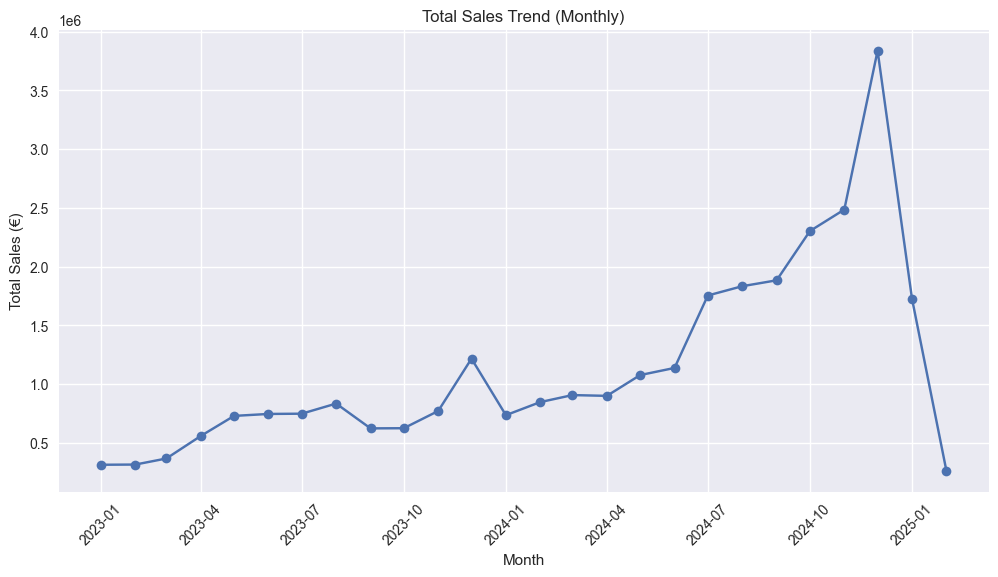

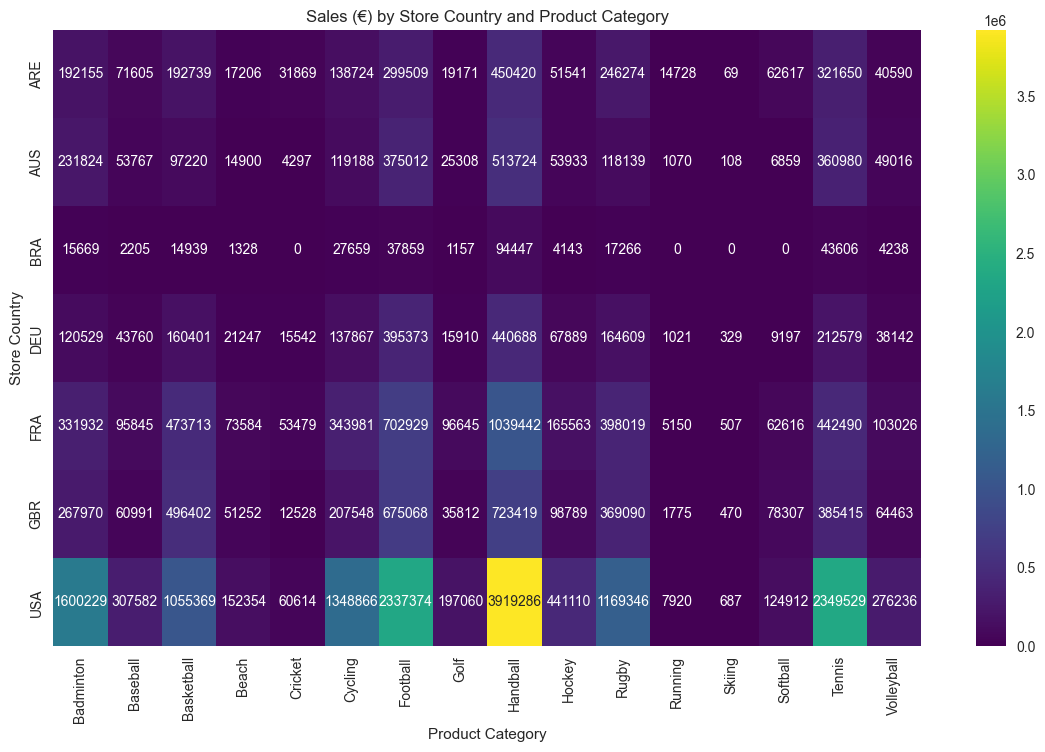

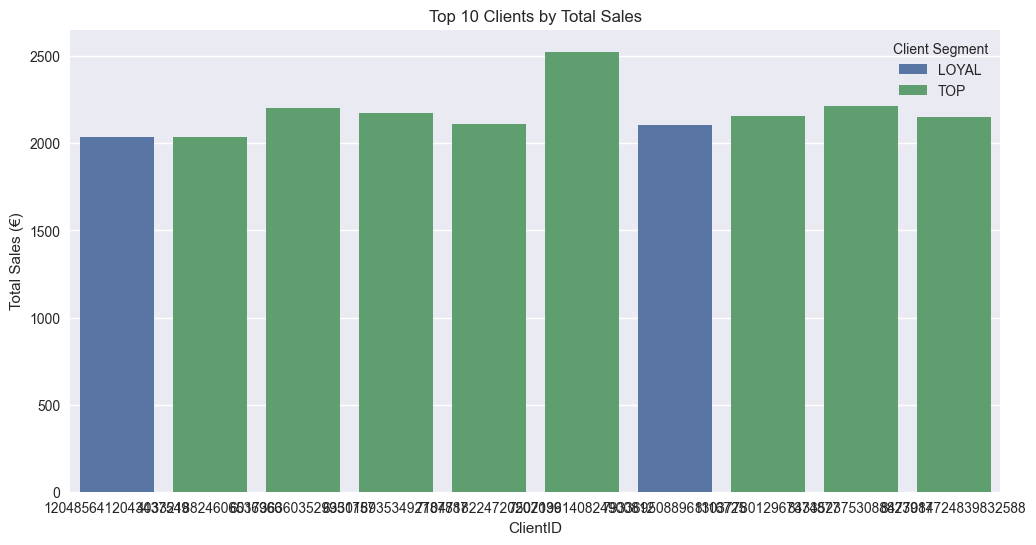

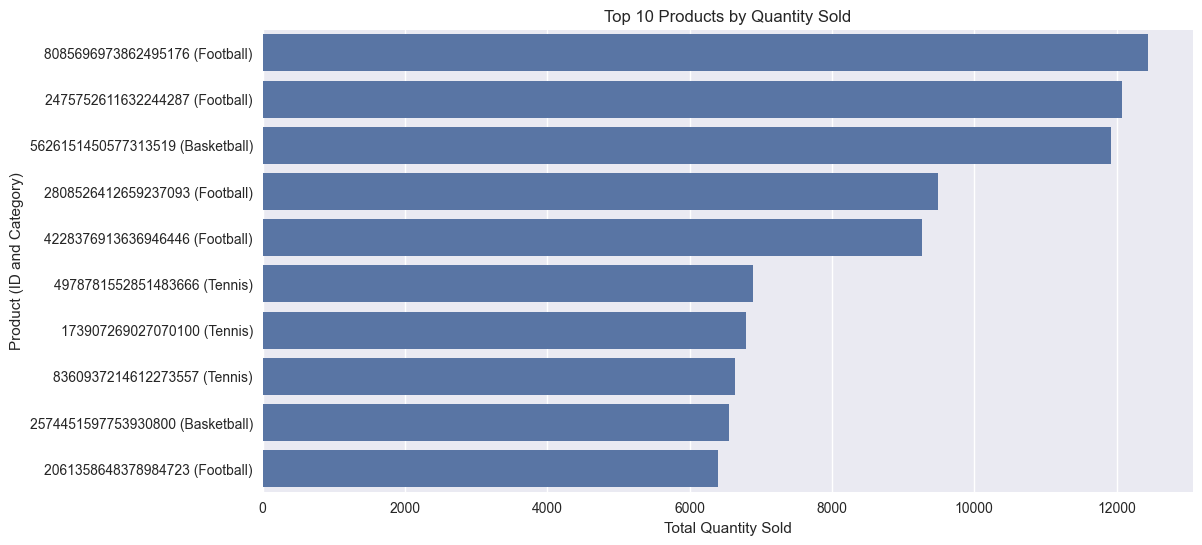

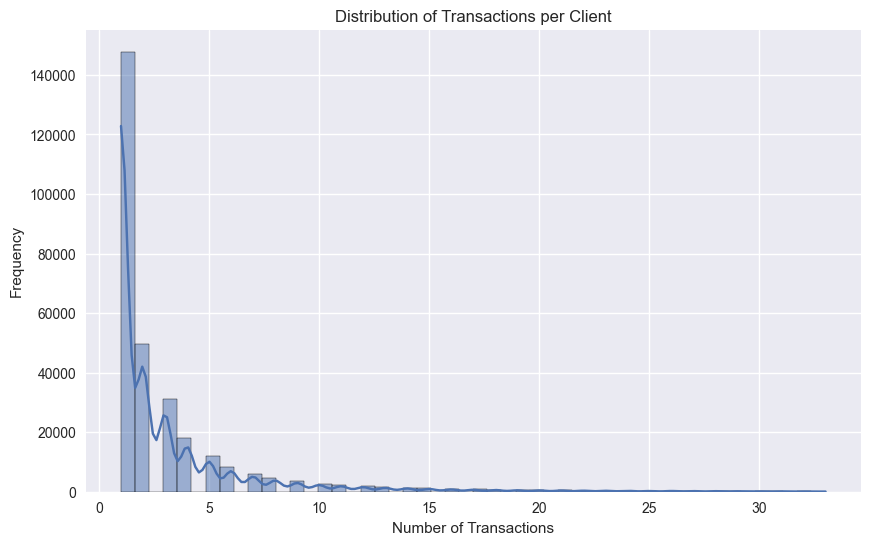

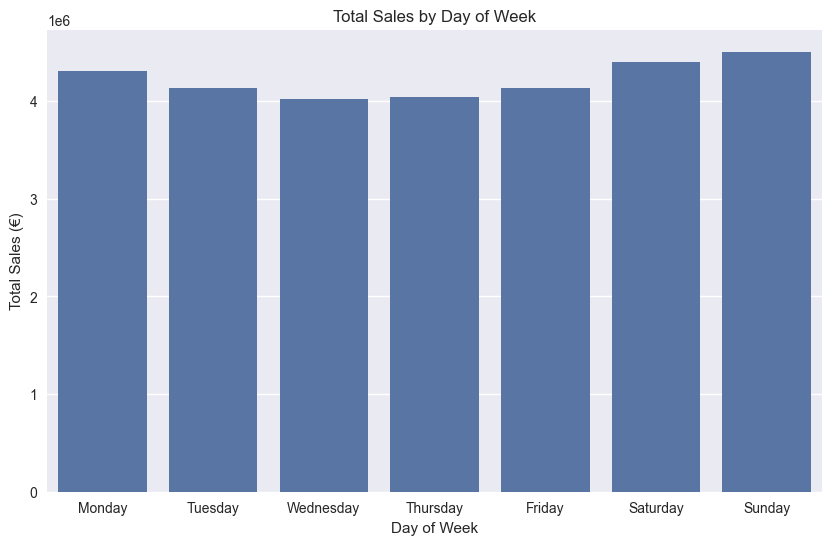

C:\Users\rikyr\AppData\Local\Temp\ipykernel_7920\4042708251.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_sales_agegroup = df_age.groupby('AgeGroup')['SalesNetAmountEuro'].mean()


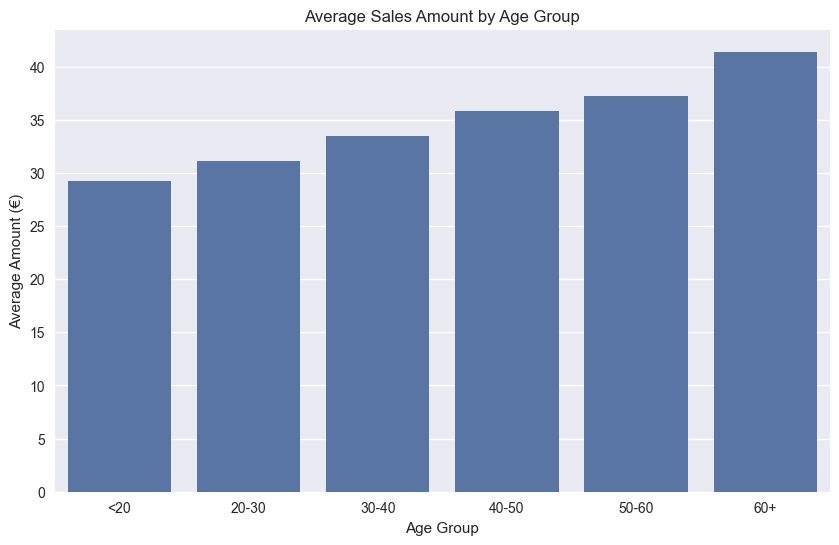

In [54]:
plt.style.use('seaborn-v0_8')

# 2.1. Sales Trend Over Time (Monthly Aggregation)
sales_by_month = final_df.groupby(final_df['TransactionDate'].dt.to_period('M'))['SalesNetAmountEuro'].sum()
sales_by_month.index = sales_by_month.index.to_timestamp()  # convert index to timestamp
plt.figure(figsize=(12, 6))
plt.plot(sales_by_month.index, sales_by_month.values, marker='o')
plt.title('Total Sales Trend (Monthly)')
plt.xlabel('Month')
plt.ylabel('Total Sales (€)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# 2.2. Heatmap: Sales by Store Country and Product Category
# Assuming final_df already has the StoreCountry and Category columns
heatmap_data = final_df.groupby(['StoreCountry', 'Category'])['SalesNetAmountEuro'].sum().unstack(fill_value=0)
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".0f")
plt.title('Sales (€) by Store Country and Product Category')
plt.xlabel('Product Category')
plt.ylabel('Store Country')
plt.show()

# 2.3. Top 10 Clients by Total Sales
client_sales = final_df.groupby('ClientID')['SalesNetAmountEuro'].sum().sort_values(ascending=False).head(10)
top_clients = client_sales.reset_index()
# If ClientSegment is in final_df use it; otherwise adjust as needed
if 'ClientSegment' in final_df.columns:
    top_clients = top_clients.merge(final_df[['ClientID','ClientSegment']].drop_duplicates(), on='ClientID', how='left')
plt.figure(figsize=(12, 6))
sns.barplot(data=top_clients, x='ClientID', y='SalesNetAmountEuro', hue='ClientSegment')
plt.title('Top 10 Clients by Total Sales')
plt.xlabel('ClientID')
plt.ylabel('Total Sales (€)')
plt.legend(title='Client Segment')
plt.show()

# 2.4. Top 10 Products by Quantity Sold
product_sales = final_df.groupby('ProductID')['Quantity_sold'].sum().sort_values(ascending=False).head(10)
top_products = product_sales.reset_index()
# If Category exists in final_df use it; otherwise adjust as needed
if 'Category' in final_df.columns:
    top_products = top_products.merge(final_df[['ProductID','Category']].drop_duplicates(), on='ProductID', how='left')
top_products['Label'] = top_products['ProductID'].astype(str) + ' (' + top_products['Category'] + ')'
plt.figure(figsize=(12, 6))
sns.barplot(data=top_products, x='Quantity_sold', y='Label', orient='h')
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product (ID and Category)')
plt.show()

# 2.6. Distribution of Transactions per Client
transactions_per_client = final_df.groupby('ClientID').size()
plt.figure(figsize=(10, 6))
sns.histplot(transactions_per_client, bins=50, kde=True)
plt.title('Distribution of Transactions per Client')
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')
plt.show()

# 2.7. Total Sales by Day of Week
if 'Weekday' not in final_df.columns:
    final_df['Weekday'] = final_df['TransactionDate'].dt.day_name()
sales_by_weekday = final_df.groupby('Weekday')['SalesNetAmountEuro'].sum()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_by_weekday = sales_by_weekday.reindex(weekday_order)
plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_weekday.index, y=sales_by_weekday.values)
plt.title('Total Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales (€)')
plt.show()

# 2.8. Average Sales by Client Age Group (using a copy of final_df)
if 'Age' in final_df.columns:
    # Create a copy that drops rows with missing Age values
    df_age = final_df.dropna(subset=['Age']).copy()
    
    # Define bins and labels for age groups
    bins = [0, 20, 30, 40, 50, 60, 100]
    labels = ['<20', '20-30', '30-40', '40-50', '50-60', '60+']
    
    # Create the AgeGroup column in the copy
    df_age['AgeGroup'] = pd.cut(df_age['Age'], bins=bins, labels=labels, right=False)
    
    # Calculate average sales for each age group
    avg_sales_agegroup = df_age.groupby('AgeGroup')['SalesNetAmountEuro'].mean()
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    sns.barplot(x=avg_sales_agegroup.index, y=avg_sales_agegroup.values)
    plt.title('Average Sales Amount by Age Group')
    plt.xlabel('Age Group')
    plt.ylabel('Average Amount (€)')
    plt.show()


In [55]:
display(final_df)

,ClientID,ProductID,TransactionDate,StoreID,StoreCountry,Quantity_in_stock,Category,FamilyLevel1,FamilyLevel2,Universe,...,ClientGender,Age,ClientCountry,ClientOptINEmail,ClientOptINPhone,Quantity_sold,SalesNetAmountEuro,product_avg_price_order,avg_price,Weekday
0,39370740138294,1440540189819119258,2024-12-17 00:00:00+00:00,7704230050291051317,GBR,0.0,Football,Jersey,Nike Away Jersey,Women,...,F,22.0,GBR,1,1,2,14.99,7.495000,8.337189,Tuesday
1,39370740138294,1830527890021285361,2024-10-27 00:00:00+00:00,4823099650757441528,GBR,0.0,Football,Shorts,Nike Dri-FIT,Women,...,F,22.0,GBR,1,1,1,13.99,13.990000,9.181570,Sunday
2,39370740138294,3095307643986324846,2024-10-28 00:00:00+00:00,4823099650757441528,GBR,0.0,Handball,Ball,Select Ultimate,Men,...,F,22.0,GBR,1,1,2,78.99,39.495000,53.883987,Monday
3,41168361649132,4786639895536460836,2024-03-03 00:00:00+00:00,7913334853958149044,FRA,3.0,Badminton,Racket,Yonex Astrox 99,Women,...,F,NaN,FRA,1,1,3,21.98,7.326667,9.759794,Sunday
4,118552773044620,7951360260357319889,2024-12-09 00:00:00+00:00,3306498059038628287,USA,1.0,Baseball,Glove,Wilson A2000,Men,...,F,52.0,USA,1,0,2,38.99,19.495000,26.422090,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902003,9223352473445645109,1102195885428775766,2025-02-05 00:00:00+00:00,7072849857188684803,ARE,13.0,Badminton,Shuttlecock,Victor Gold Champion,Men,...,F,NaN,ARE,0,0,1,27.99,27.990000,16.059312,Wednesday
902004,9223352473445645109,5760088997185117368,2024-05-08 00:00:00+00:00,7072849857188684803,ARE,0.0,Tennis,Ball,Wilson US Open,Men,...,F,NaN,ARE,0,0,1,26.99,26.990000,15.618155,Wednesday
902005,9223352473445645109,5760088997185117368,2024-05-21 00:00:00+00:00,7072849857188684803,ARE,0.0,Tennis,Ball,Wilson US Open,Men,...,F,NaN,ARE,0,0,1,5.99,5.990000,15.618155,Tuesday
902006,9223352473445645109,5760088997185117368,2024-05-23 00:00:00+00:00,7072849857188684803,ARE,0.0,Tennis,Ball,Wilson US Open,Men,...,F,NaN,ARE,0,0,2,23.99,11.995000,15.618155,Thursday


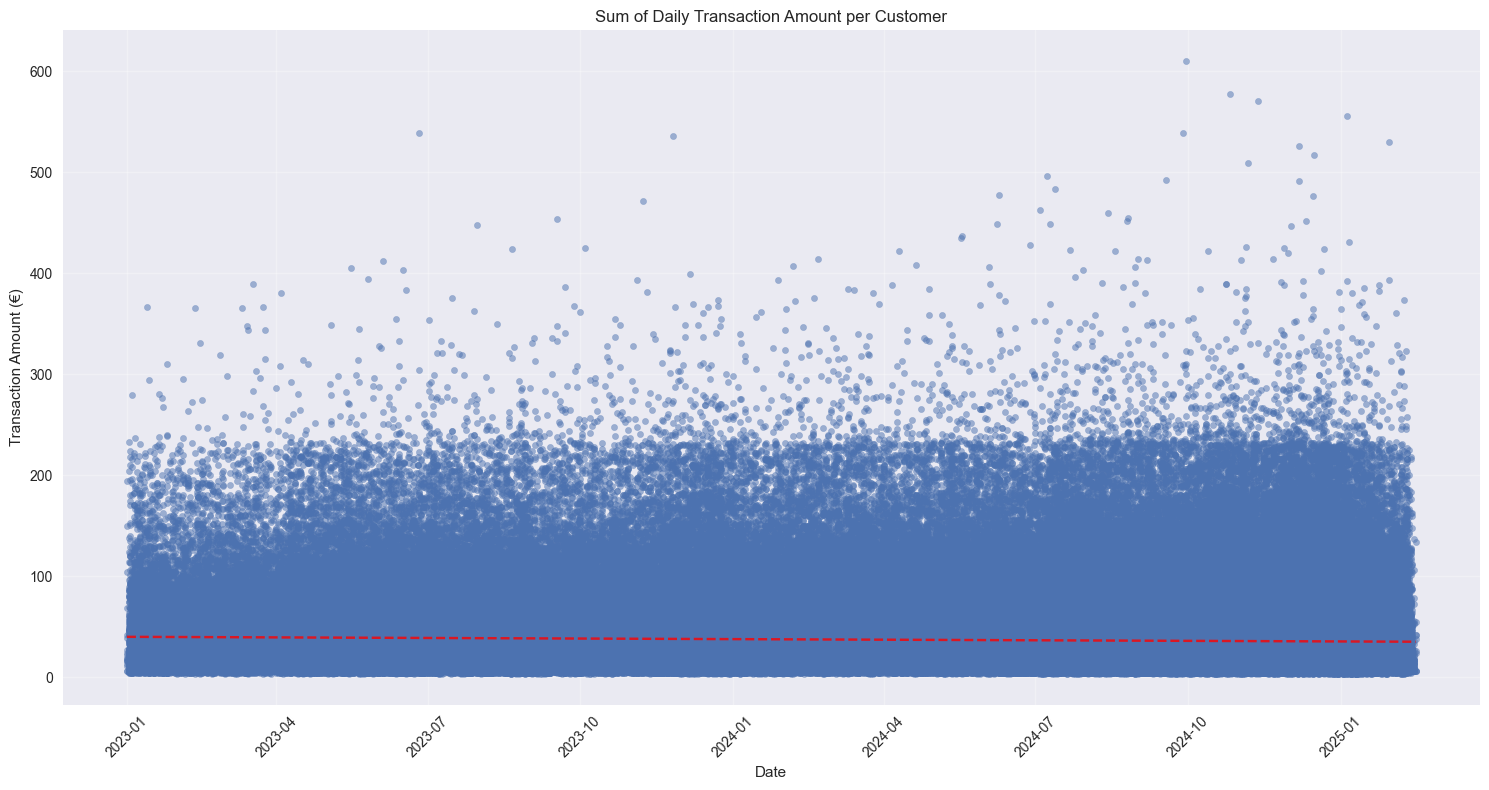

In [56]:
# Group by date and customer, find the sum of transaction amounts for each day per customer
daily_customer_sum = final_df.groupby(['TransactionDate', 'ClientID'])['SalesNetAmountEuro'].sum().reset_index()

# Create figure
plt.figure(figsize=(15, 8))

# Create scatter plot
plt.scatter(daily_customer_sum['TransactionDate'], 
            daily_customer_sum['SalesNetAmountEuro'],
            alpha=0.5,
            s=20)

# Customize the plot
plt.title('Sum of Daily Transaction Amount per Customer')
plt.xlabel('Date')
plt.ylabel('Transaction Amount (€)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Add a trend line
z = np.polyfit(daily_customer_sum['TransactionDate'].astype(np.int64), 
               daily_customer_sum['SalesNetAmountEuro'], 1)
p = np.poly1d(z)
plt.plot(daily_customer_sum['TransactionDate'],
         p(daily_customer_sum['TransactionDate'].astype(np.int64)),
         "r--", alpha=0.8)

plt.tight_layout()
plt.show()


In [57]:
final_df.to_csv('final_dataframe.csv', index=False)

In [58]:
# List of initial dataframes and their names
initial_dataframes = [clients_df, products_df, stocks_df, stores_df, transactions_df]
initial_dataframe_names = ['clients_df', 'products_df', 'stocks_df', 'stores_df', 'transactions_df']

# Columns of the final dataframe
final_columns = final_df.columns.tolist()

# Check for missing columns in each initial dataframe
for df, name in zip(initial_dataframes, initial_dataframe_names):
    missing_columns = [col for col in df.columns if col not in final_columns]
    if missing_columns:
        print(f"Missing columns in {name}: {missing_columns}")
    else:
        print(f"All columns of {name} are present in final_df")

All columns of clients_df are present in final_df
All columns of products_df are present in final_df
Missing columns in stocks_df: ['Quantity']
All columns of stores_df are present in final_df
Missing columns in transactions_df: ['SaleTransactionDate', 'Quantity']


In [59]:
final_df

,ClientID,ProductID,TransactionDate,StoreID,StoreCountry,Quantity_in_stock,Category,FamilyLevel1,FamilyLevel2,Universe,...,ClientGender,Age,ClientCountry,ClientOptINEmail,ClientOptINPhone,Quantity_sold,SalesNetAmountEuro,product_avg_price_order,avg_price,Weekday
0,39370740138294,1440540189819119258,2024-12-17 00:00:00+00:00,7704230050291051317,GBR,0.0,Football,Jersey,Nike Away Jersey,Women,...,F,22.0,GBR,1,1,2,14.99,7.495000,8.337189,Tuesday
1,39370740138294,1830527890021285361,2024-10-27 00:00:00+00:00,4823099650757441528,GBR,0.0,Football,Shorts,Nike Dri-FIT,Women,...,F,22.0,GBR,1,1,1,13.99,13.990000,9.181570,Sunday
2,39370740138294,3095307643986324846,2024-10-28 00:00:00+00:00,4823099650757441528,GBR,0.0,Handball,Ball,Select Ultimate,Men,...,F,22.0,GBR,1,1,2,78.99,39.495000,53.883987,Monday
3,41168361649132,4786639895536460836,2024-03-03 00:00:00+00:00,7913334853958149044,FRA,3.0,Badminton,Racket,Yonex Astrox 99,Women,...,F,NaN,FRA,1,1,3,21.98,7.326667,9.759794,Sunday
4,118552773044620,7951360260357319889,2024-12-09 00:00:00+00:00,3306498059038628287,USA,1.0,Baseball,Glove,Wilson A2000,Men,...,F,52.0,USA,1,0,2,38.99,19.495000,26.422090,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902003,9223352473445645109,1102195885428775766,2025-02-05 00:00:00+00:00,7072849857188684803,ARE,13.0,Badminton,Shuttlecock,Victor Gold Champion,Men,...,F,NaN,ARE,0,0,1,27.99,27.990000,16.059312,Wednesday
902004,9223352473445645109,5760088997185117368,2024-05-08 00:00:00+00:00,7072849857188684803,ARE,0.0,Tennis,Ball,Wilson US Open,Men,...,F,NaN,ARE,0,0,1,26.99,26.990000,15.618155,Wednesday
902005,9223352473445645109,5760088997185117368,2024-05-21 00:00:00+00:00,7072849857188684803,ARE,0.0,Tennis,Ball,Wilson US Open,Men,...,F,NaN,ARE,0,0,1,5.99,5.990000,15.618155,Tuesday
902006,9223352473445645109,5760088997185117368,2024-05-23 00:00:00+00:00,7072849857188684803,ARE,0.0,Tennis,Ball,Wilson US Open,Men,...,F,NaN,ARE,0,0,2,23.99,11.995000,15.618155,Thursday


In [60]:
# Check missing values in final_df as percentages
missing_values = (final_df.isnull().sum() / len(final_df) * 100).round(2)
print("Missing values in final_df (%):")
print(missing_values)

Missing values in final_df (%):
ClientID                    0.00
ProductID                   0.00
TransactionDate             0.00
StoreID                     0.00
StoreCountry                0.00
Quantity_in_stock           0.00
Category                    0.00
FamilyLevel1                0.00
FamilyLevel2                0.00
Universe                    0.00
ClientSegment               0.00
ClientGender                5.46
Age                        63.40
ClientCountry               0.00
ClientOptINEmail            0.00
ClientOptINPhone            0.00
Quantity_sold               0.00
SalesNetAmountEuro          0.00
product_avg_price_order     0.00
avg_price                   0.00
Weekday                     0.00
dtype: float64
